# Objective 2: 3D Image Segmentation

## Import libraries

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt,  animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import cv2
from skimage import measure
from skimage.segmentation import flood
from scipy.ndimage import label, binary_dilation
from IPython.display import Image



import os
import imageio

import constants as ct
import utils
from utils import  load_ct_series, load_segmentation, load_pixelarray_positions, reslice_segmentations

## 1.  Extract bounding box and centroid from Tumor mask of Reference Image

- Load segmentation masks and image

In [3]:
slice_liver = ct.LIVER_SEGMENTATION 
slice_tumor = ct.TUMOR_SEGMENTATION 
ct_volume, slice_positions, _ = load_ct_series(ct.REFERENCE_IMAGE)

The reference CT volume has a shape of: (54, 512, 512)


In [4]:
liver_segmented =load_segmentation(slice_liver)
liver_array, liver_pos = load_pixelarray_positions(liver_segmented)
liver_volume = reslice_segmentations(ct_volume.shape,liver_pos,slice_positions, liver_array, label_value=1)


tumor_segmented = load_segmentation(slice_tumor)
tumor_array, tumor_pos = load_pixelarray_positions(tumor_segmented)
tumor_volume = reslice_segmentations(ct_volume.shape,tumor_pos,slice_positions, tumor_array, label_value=2)

In [5]:
ct_volume = np.flip(ct_volume, axis=0) 
liver_volume = np.flip(liver_volume, axis=0)
tumor_volume =  np.flip(tumor_volume, axis=0) 

- Bounding Box (https://www.immersivelimit.com/tutorials/create-bounding-box-from-segmentation)

In [6]:
def extract_bbox(segmentation):
    segmentation = np.where(segmentation > 0)
    z_min = int(np.min(segmentation[0]))
    z_max = int(np.max(segmentation[0]))
    y_min = int(np.min(segmentation[1]))
    y_max = int(np.max(segmentation[1]))
    x_min = int(np.min(segmentation[2]))
    x_max = int(np.max(segmentation[2]))
    return ((z_min,z_max),(y_min, y_max),(x_min, x_max))

In [7]:
liver_bbox = extract_bbox(liver_volume)
print(liver_bbox)
tumor_bbox = extract_bbox(tumor_volume)
print(tumor_bbox)

((6, 37), (106, 315), (85, 405))
((12, 22), (161, 240), (151, 252))


- Centroid (https://github.com/TehseenHasan/yolo5-object-detection-and-centroid-finding/blob/main/yolo5_detection.py)

In [8]:
def centroid(bbox): 
    z_min, z_max = bbox[0]
    y_min, y_max = bbox[1]
    x_min, x_max = bbox[2]

    cz = int((z_min+z_max)/2.0)
    cy = int((y_min+y_max)/2.0) 
    cx = int((x_min+x_max)/2.0)

    return (cz, cy, cx)

In [9]:
liver_centroid = centroid(liver_bbox)
print(liver_centroid)
tumor_centroid = centroid(tumor_bbox)
print(tumor_centroid)

(21, 210, 245)
(17, 200, 201)


Visualize bounding box and contour 

Umbral de Otsu: -1000


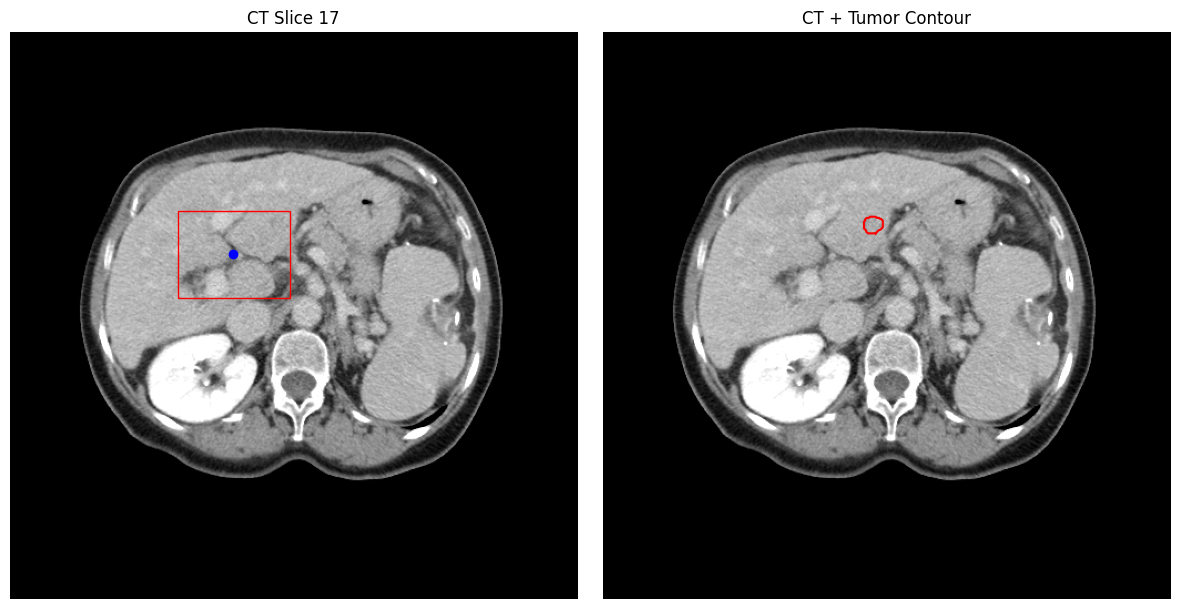

In [33]:
slice_idx = 17
body_mask_reference = utils.segment_body(ct_volume)
ct_volumeReference = utils.apply_body_mask(ct_volume, body_mask_reference)
slice_saxial = utils.apply_windowing(ct_volumeReference[slice_idx], 40, 350)
mask_slice = (tumor_volume[slice_idx] == 2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: CT slice with bounding boxes & centroid ---
axs[0].imshow(slice_saxial, cmap='gray')
(z_min, z_max), (y_min, y_max), (x_min, x_max) = tumor_bbox
centroid_z, centroid_y, centroid_x = tumor_centroid

if z_min <= slice_idx <= z_max:
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                            linewidth=1, edgecolor='r', facecolor='none')
    axs[0].add_patch(rect)

    if int(round(centroid_z)) == slice_idx:
        axs[0].plot(centroid_x, centroid_y, 'bo')

axs[0].set_title(f"CT Slice {slice_idx}")
axs[0].axis('off')

# --- Right: CT slice with tumor mask overlaid ---
axs[1].imshow(slice_saxial, cmap='gray')
contours = measure.find_contours(mask_slice.astype(float), level=0.5)
for contour in contours:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')

axs[1].set_title("CT + Tumor Contour")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Get 3D visualization of the masks

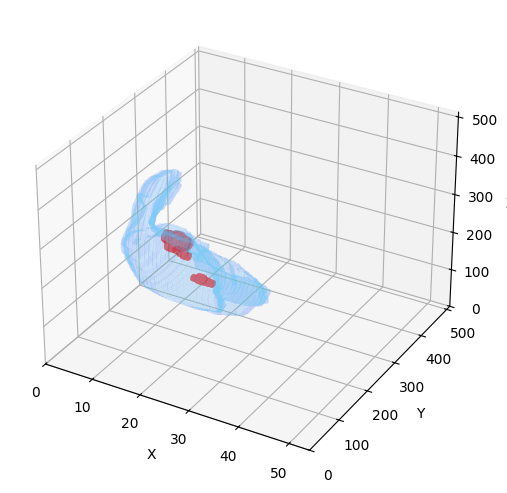

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

# Liver mesh
verts_liver, faces_liver, _, _ = measure.marching_cubes(liver_volume, level=0.5)
mesh_liver = Poly3DCollection(verts_liver[faces_liver], alpha=0.2)
mesh_liver.set_facecolor([0.5, 0.8, 1.0])  # Light blue
ax.add_collection3d(mesh_liver)

# Tumor mesh
verts_tumor, faces_tumor, _, _ = measure.marching_cubes(tumor_volume, level=0.5)
mesh_tumor = Poly3DCollection(verts_tumor[faces_tumor], alpha=0.6)
mesh_tumor.set_facecolor([1, 0, 0])  # Red
ax.add_collection3d(mesh_tumor)

# Set limits
max_shape = np.max([liver_volume.shape, tumor_volume.shape], axis=0)
ax.set_xlim(0, max_shape[0])
ax.set_ylim(0, max_shape[1])
ax.set_zlim(0, max_shape[2])

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

Get each bounding box and centroid

In [12]:
labeled_mask, num_labels = label(tumor_volume)
print(num_labels)
print(np.unique(labeled_mask)) 

bboxes = []
for i in range(1,4):
    bboxes.append(extract_bbox(labeled_mask==i))

print(len(bboxes))

centroids = []
for i in range(0,3):
    centroids.append(centroid(bboxes[i]))

print(len(centroids))

3
[0 1 2 3]
3
3


Visualize bounding boxes and contours

Umbral de Otsu: -1000


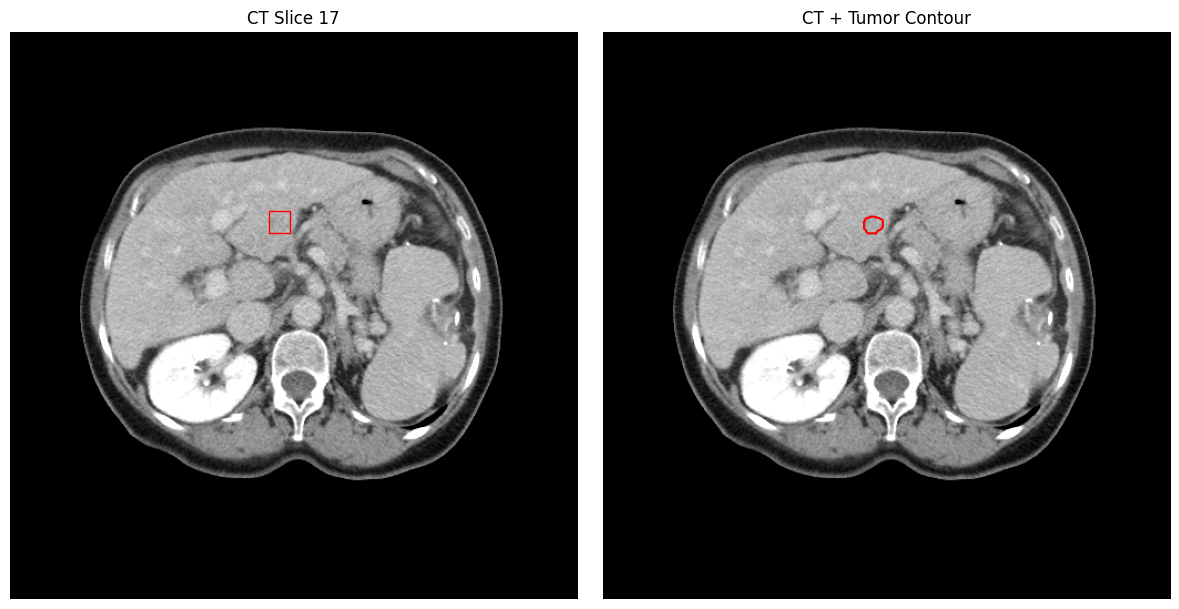

In [36]:
slice_idx = 17
body_mask_reference = utils.segment_body(ct_volume)
ct_volumeReference = utils.apply_body_mask(ct_volume, body_mask_reference)
slice_saxial = utils.apply_windowing(ct_volumeReference[slice_idx], 40, 350)
mask_slice = (tumor_volume[slice_idx] == 2)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# --- Left: CT slice with bounding boxes & centroid ---
axs[0].imshow(slice_saxial, cmap='gray')
for i in range(len(bboxes)):
    (z_min, z_max), (y_min, y_max), (x_min, x_max) = bboxes[i]
    centroid_z, centroid_y, centroid_x = centroids[i]

    if z_min <= slice_idx <= z_max:
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=1, edgecolor='r', facecolor='none')
        axs[0].add_patch(rect)

        if int(round(centroid_z)) == slice_idx:
            axs[0].plot(centroid_x, centroid_y, 'bo')

axs[0].set_title(f"CT Slice {slice_idx}")
axs[0].axis('off')

# --- Right: CT slice with tumor mask overlaid ---
axs[1].imshow(slice_saxial, cmap='gray')
contours = measure.find_contours(mask_slice.astype(float), level=0.5)
for contour in contours:
    axs[1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')

axs[1].set_title("CT + Tumor Contour")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Generate gif going through each slice: show bounding box and centroid

In [14]:
frames = []
for slice_idx in range(1,tumor_volume.shape[0]):
    slice_saxial = utils.apply_windowing(ct_volumeReference[slice_idx], 40, 350)
    mask_slice = (tumor_volume[slice_idx] == 2)
    contours = measure.find_contours(mask_slice.astype(float), level=0.5)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Left: CT with bounding boxes and centroids
    axs[0].imshow(slice_saxial, cmap='gray')
    for i in range(len(bboxes)):
        (z_min, z_max), (y_min, y_max), (x_min, x_max) = bboxes[i]
        centroid_z, centroid_y, centroid_x = centroids[i]

        if z_min <= slice_idx <= z_max:
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=1, edgecolor='r', facecolor='none')
            axs[0].add_patch(rect)

            if int(round(centroid_z)) == slice_idx:
                axs[0].plot(centroid_x, centroid_y, 'bo')

    axs[0].set_title(f"CT Slice {slice_idx}")
    axs[0].axis('off')

    # Right: CT with contour overlay (label == 2 only)
    axs[1].imshow(slice_saxial, cmap='gray')
    for contour in contours:
        axs[1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
    axs[1].set_title("Tumor Contour")
    axs[1].axis('off')

    plt.tight_layout()

    frame_path = f"gif_frames/slice_{slice_idx:03d}.png"
    plt.savefig(frame_path, bbox_inches='tight')
    plt.close()
    frames.append(imageio.imread(frame_path))

# Create GIF
imageio.mimsave("tumor_visualization.gif", frames, duration=300)


C:\Users\Aina\AppData\Local\Temp\ipykernel_15988\2047683838.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


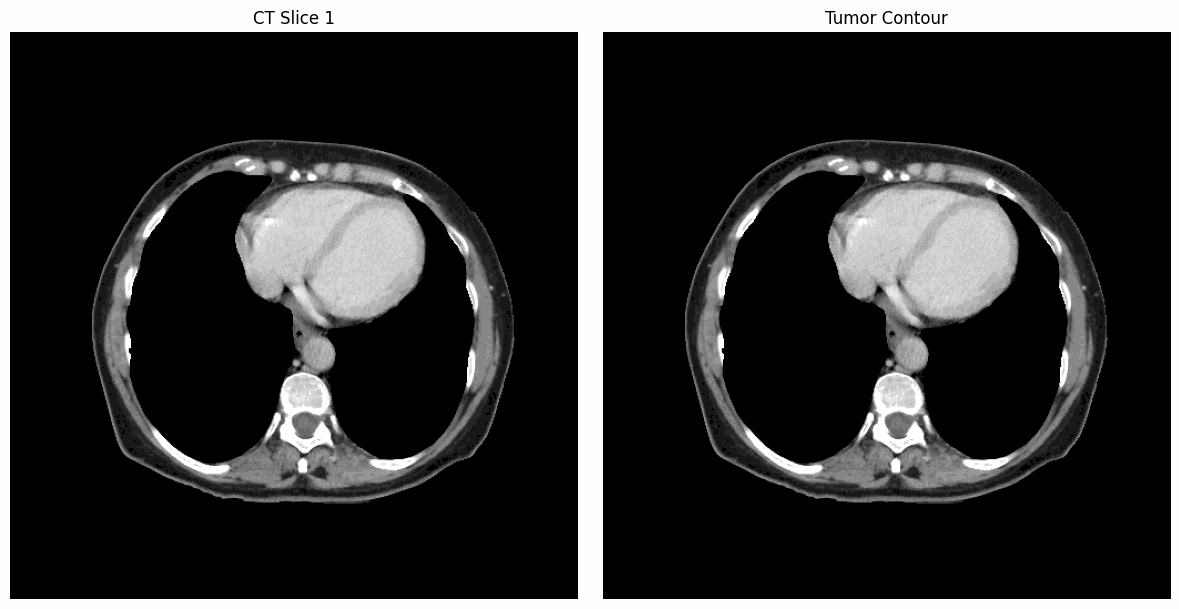

In [15]:
Image(filename='gif_frames/tumor_visualization.gif')

## Visualization and Assessment

In [16]:
def plot_ct_and_segmentation(mask, id, type, alpha):
    if(type== 'coronal'):
        slice_ct = ct_volume[:,id,:]
        slice_auto = mask[:,id,:]
    elif(type=='sagittal'):
        slice_ct = ct_volume[:,:,id]
        slice_auto = mask[:,:,id]
    
    img_min = np.min(slice_ct)
    img_max = np.max(slice_ct)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    cm = matplotlib.colormaps['prism']
    mask_bone_cmapped = cm(slice_auto)
    mask_bone_cmapped = mask_bone_cmapped * \
        (slice_auto > 0)[..., np.newaxis].astype('bool')
    
    cm = matplotlib.colormaps['bone']
    img_cmapped = cm(slice_ct)

    axs[0].imshow(slice_ct,vmin=img_min,vmax= img_max, cmap='bone', aspect=(5.0/ 0.703125))
    axs[0].set_title('CT Image')

    axs[1].imshow(img_cmapped * (1-alpha) + mask_bone_cmapped * alpha, vmin=img_min,vmax= img_max,cmap='bone',aspect=(5.0/ 0.703125))
    axs[1].set_title('CT + Mask')

    plt.show()

def plot_gt_and_segmentation(mask, gt, id, type):
    if(type== 'coronal'):
        slice_gt = gt[:,id,:]
        slice_auto = mask[:,id,:]
    elif(type=='sagittal'):
        slice_gt = gt[:,:,id]
        slice_auto = mask[:,:,id]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    overlay = np.zeros((*slice_gt.shape, 3), dtype=np.float32)
    overlay[:, :, 0] = slice_gt & ~slice_auto
    overlay[:, :, 1] = ~slice_gt & slice_auto
    overlay[:, :, 2] = slice_gt & slice_auto

    axs[0].imshow(slice_gt,cmap='gray', aspect=(5.0/ 0.703125))
    axs[0].set_title('Groud Truth')

    axs[1].imshow(slice_auto,cmap='gray',aspect=(5.0/ 0.703125))
    axs[1].set_title('Mask')
    
    
    overlay = np.clip(overlay, 0, 1)
    axs[2].imshow(overlay,aspect=(5.0/ 0.703125))
    axs[2].set_title('Comparison: Red -> GT, Green -> Segmentation, Blue -> Union')
    plt.show()

def plot_all(mask, gt, id, type, alpha):
    if(type== 'coronal'):
        slice_ct = ct_volume[:,id,:]
        slice_gt = gt[:,id,:]
        slice_auto = mask[:,id,:]
    elif(type=='sagittal'):
        slice_ct = ct_volume[:,:,id]
        slice_gt = gt[:,id,:]
        slice_auto = mask[:,:,id]
    
    img_min = np.min(slice_ct)
    img_max = np.max(slice_ct)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
   
    
    cm = matplotlib.colormaps['bone']
    img_cmapped = cm(slice_ct)

    cm = matplotlib.colormaps['Set1']
    mask_bone_cmapped = cm(slice_auto)
    mask_bone_cmapped = mask_bone_cmapped * \
        (slice_auto > 0)[..., np.newaxis].astype('bool')
    
    gt_cmapped = cm(slice_gt)
    gt_cmapped = gt_cmapped * \
        (slice_gt > 0)[..., np.newaxis].astype('bool')

    axs[0].imshow(img_cmapped * (1-alpha) + gt_cmapped * alpha,vmin=img_min,vmax= img_max, cmap='bone', aspect=(5.0/ 0.703125))
    axs[0].set_title('CT Image')


    axs[1].imshow(img_cmapped * (1-alpha) + mask_bone_cmapped * alpha, vmin=img_min,vmax= img_max,cmap='bone',aspect=(5.0/ 0.703125))
    axs[1].set_title('CT + Mask')
    

    overlay = np.zeros_like(slice_gt, dtype=np.float32)
    overlay[(slice_gt == 2) & (slice_auto ==1)]=1
    overlay[(slice_gt == 0) & (slice_auto ==1)]=2
    overlay[(slice_gt == 2) & (slice_auto ==0)]=3


    overlay_cmapped = cm(overlay)
    overlay_cmapped = overlay_cmapped * \
        (overlay > 0)[..., np.newaxis].astype('bool')

    axs[2].imshow(img_cmapped * (1-alpha) + overlay_cmapped * alpha, vmin=img_min,vmax= img_max,aspect=(5.0/ 0.703125))
    axs[2].set_title('')

    plt.show()

Metrics from class activities:

In [17]:
def perpixel_performance_measures(
        mask_reference: np.ndarray,
        mask_prediction: np.ndarray
        ) -> tuple[int, int, int, int]:
    """ Compute the number of true/false positives and true/false negatives from two boolean masks."""
    true_negatives = np.sum((mask_reference == 0) & (mask_prediction == 0))
    true_positives = np.sum((mask_reference == 1) & (mask_prediction == 1))
    false_negatives = np.sum((mask_reference == 1) & (mask_prediction == 0))
    false_positives = np.sum((mask_reference == 0) & (mask_prediction == 1))
    return true_positives, true_negatives, false_positives, false_negatives

In [18]:
def perimage_performance_measures(mask_reference, mask_prediction):
    """ Compute the sensitivity, specificity and f1_score from two boolean masks. """
    tp, tn, fp, fn = perpixel_performance_measures(mask_reference, mask_prediction)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * tp / (2 * tp + fp + fn)
    return sensitivity, specificity, f1_score

In [19]:
def dice_coefficient(mask_reference, mask_prediction):
    intersection = np.sum(mask_reference * mask_prediction)
    return (2. * intersection) / (np.sum(mask_reference) + np.sum(mask_prediction))

# Analysis of tumors properties

In [20]:
body_mask_reference = utils.segment_body(ct_volume)
ct_volume = utils.apply_body_mask(ct_volume, body_mask_reference)

Umbral de Otsu: -478


In [21]:
def computing_statistics(mask, label_id,pixel_area, voxel_volume):
    stats = {}
    volume = np.sum(mask) * voxel_volume
    slice_sums = mask.sum(axis=(1, 2))
    max_slice_idx = np.argmax(slice_sums)
    tumor_slice = mask[max_slice_idx]
    perimeter = perimeter_2d(tumor_slice)
    area = np.sum(tumor_slice) * pixel_area

    intensities = ct_volume[mask]

    stats = {
            'tumor_id': label_id,
            'volume_mm3': volume,
            'area_mm2': area,
            'perimeter_voxels': perimeter,
            'max_intensity': np.max(intensities),
            'min_intensity': np.min(intensities),
            'mean_intensity': np.mean(intensities),
            'median_intensity': np.median(intensities),
            'std_intensity': np.std(intensities),
        }
    return stats

def perimeter_2d(binary_slice):
    dilated = binary_dilation(binary_slice)
    return np.sum(dilated ^ binary_slice)

def analyze_multiple_tumors_and_liver(tumor_mask, labeled_mask, num_tumors,liver_mask, ct_volume, voxel_spacing=(0.703125, 0.703125, 5.)):
    """
    Compute stats for each connected tumor and for the liver (excluding tumor).
    """
    results = {}
    voxel_volume = np.prod(voxel_spacing)
    pixel_area = voxel_spacing[1] * voxel_spacing[2]

    # Binary tumor mask
    tumor_binary = tumor_mask == 2
    results['num_tumors'] = num_tumors
    tumor_stats = []

    for label_id in range(1, num_tumors + 1):
        tumor = labeled_mask == label_id
        tumor_stats.append(computing_statistics(tumor, label_id, pixel_area, voxel_volume))

    results['tumors'] = tumor_stats

    # Liver mask excluding tumors
    liver_binary = (liver_mask == 1) & (~tumor_binary)
    stats = computing_statistics(liver_binary,4, pixel_area,voxel_volume)
    results['liver'] = stats

    return results


In [22]:
results = analyze_multiple_tumors_and_liver(tumor_volume, labeled_mask,num_labels, liver_volume, ct_volume)

for tumor in results['tumors']:
    print(f"Tumor ID: {tumor['tumor_id']}")
    print(f"  Volume: {tumor['volume_mm3']:.2f} mm³")
    print(f"  Area (2D slice): {tumor['area_mm2']:.2f} mm²")
    print(f"  Perimeter (2D slice): {tumor['perimeter_voxels']} voxels")
    print(f"  Intensity Max: {tumor['max_intensity']:.2f}")
    print(f"  Intensity Min: {tumor['min_intensity']:.2f}")
    print(f"  Intensity Mean: {tumor['mean_intensity']:.2f}")
    print(f"  Intensity Median: {tumor['median_intensity']:.2f}")
    print(f"  Intensity Std Dev: {tumor['std_intensity']:.2f}")

print("Liver (excluding tumor):")
liver = results['liver']
print(f"  Volume: {liver['volume_mm3']:.2f} mm³")
print(f"  Area (2D slice): {liver['area_mm2']:.2f} mm²")
print(f"  Perimeter (2D slice): {liver['perimeter_voxels']} voxels")
print(f"  Intensity Max: {liver['max_intensity']:.2f}")
print(f"  Intensity Min: {liver['min_intensity']:.2f}")
print(f"  Intensity Mean: {liver['mean_intensity']:.2f}")
print(f"  Intensity Median: {liver['median_intensity']:.2f}")
print(f"  Intensity Std Dev: {liver['std_intensity']:.2f}")

Tumor ID: 1
  Volume: 11842.99 mm³
  Area (2D slice): 4900.78 mm²
  Perimeter (2D slice): 125 voxels
  Intensity Max: 146.00
  Intensity Min: 45.00
  Intensity Mean: 96.29
  Intensity Median: 96.00
  Intensity Std Dev: 14.40
Tumor ID: 2
  Volume: 1579.56 mm³
  Area (2D slice): 762.89 mm²
  Perimeter (2D slice): 52 voxels
  Intensity Max: 132.00
  Intensity Min: 40.00
  Intensity Mean: 93.34
  Intensity Median: 94.00
  Intensity Std Dev: 14.96
Tumor ID: 3
  Volume: 2254.39 mm³
  Area (2D slice): 1184.77 mm²
  Perimeter (2D slice): 62 voxels
  Intensity Max: 143.00
  Intensity Min: 60.00
  Intensity Mean: 100.84
  Intensity Median: 101.00
  Intensity Std Dev: 14.46
Liver (excluding tumor):
  Volume: 1132373.47 mm³
  Area (2D slice): 105205.08 mm²
  Perimeter (2D slice): 807 voxels
  Intensity Max: 215.00
  Intensity Min: -154.00
  Intensity Mean: 109.39
  Intensity Median: 110.00
  Intensity Std Dev: 16.92


# Segmentation

### Thresholding 

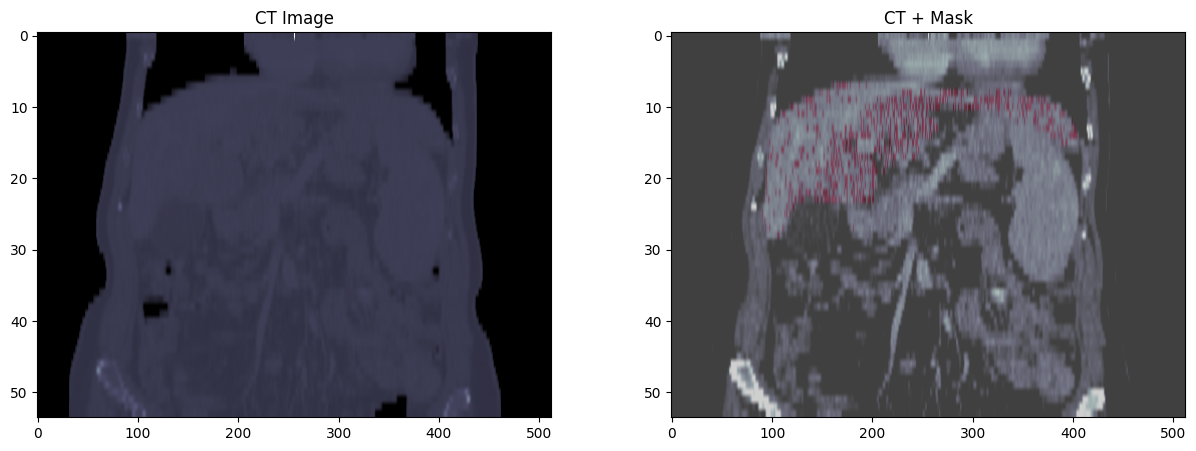

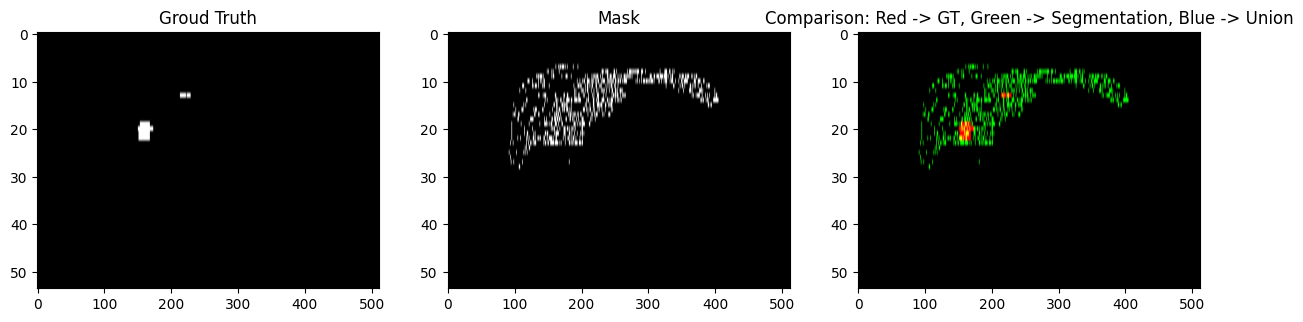

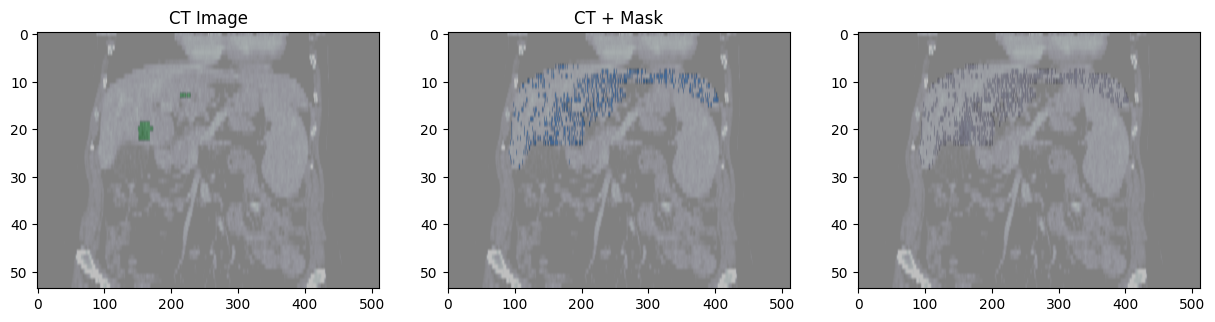

In [38]:
binary_mask = np.zeros_like(ct_volume, dtype=np.uint8)
for i in range(ct_volume.shape[0]):
    mask = (ct_volume[i] >= 40) & (ct_volume[i] <= 110)
    binary_mask[i] = ct_volume[i] * mask 

final_mask = binary_mask & (liver_volume > 0)

plot_ct_and_segmentation(final_mask,200,'coronal',0.25)
plot_gt_and_segmentation(final_mask,tumor_volume,200,'coronal')
plot_all(final_mask,tumor_volume,200,'coronal',0.5)

In [24]:
print(perpixel_performance_measures(tumor_volume,final_mask))
print(perimage_performance_measures(tumor_volume, final_mask))
print(dice_coefficient(tumor_volume, final_mask))

(np.int64(0), np.int64(14039002), np.int64(110432), np.int64(0))
(np.float64(nan), np.float64(0.9921953061868057), np.float64(0.0))
0.08475047900716325


C:\Users\Aina\AppData\Local\Temp\ipykernel_15988\3159552078.py:4: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = tp / (tp + fn)


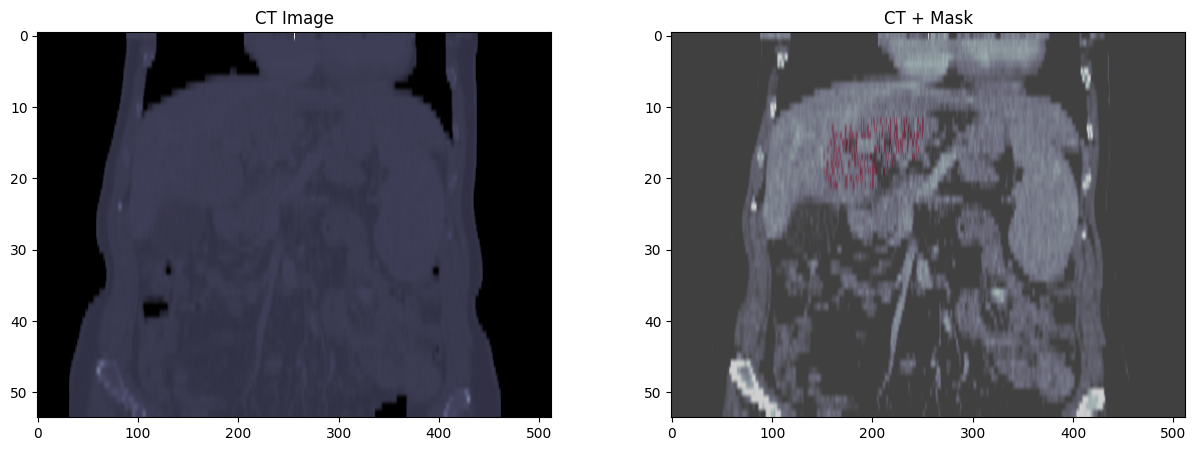

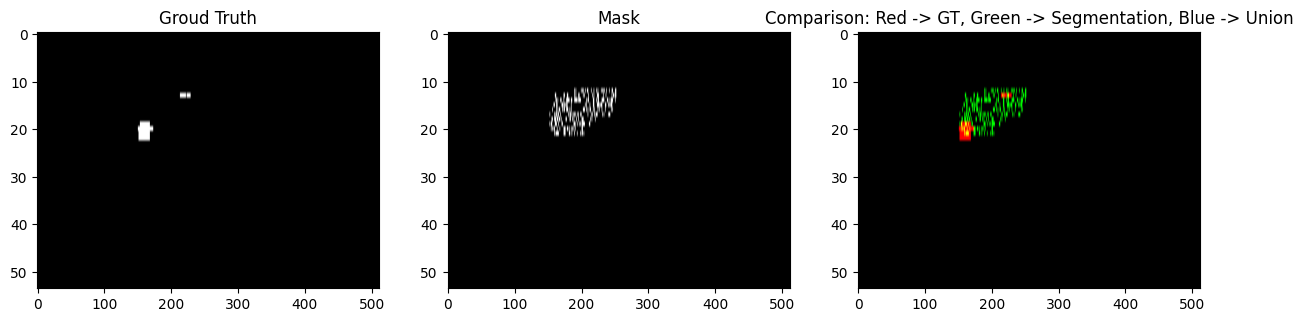

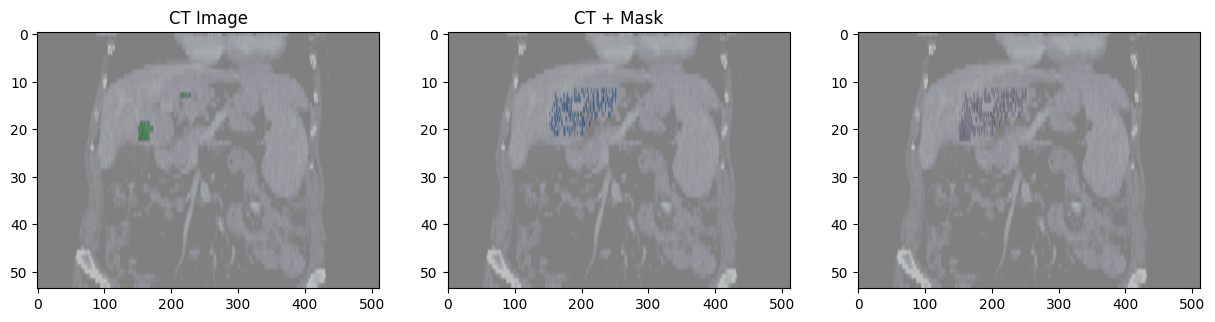

In [43]:
binary_mask = np.zeros_like(ct_volume, dtype=np.uint8)
for i in range(ct_volume.shape[0]):
    mask = (ct_volume[i] >= 40) & (ct_volume[i] <= 110)
    binary_mask[i] = ct_volume[i] * mask

combined_mask = binary_mask & (liver_volume > 0)

(zmin, zmax), (ymin, ymax), (xmin, xmax) = tumor_bbox
final_mask = np.zeros_like(ct_volume, dtype=np.uint8)
final_mask[zmin:zmax, ymin:ymax, xmin:xmax] = combined_mask[zmin:zmax, ymin:ymax, xmin:xmax]

# Step 4: Plotting
plot_ct_and_segmentation(final_mask, 200, 'coronal', 0.25)
plot_gt_and_segmentation(final_mask, tumor_volume, 200, 'coronal')
plot_all(final_mask, tumor_volume, 200, 'coronal', 0.5)

In [44]:
print(perpixel_performance_measures(tumor_volume,final_mask))
print(perimage_performance_measures(tumor_volume, final_mask))
print(dice_coefficient(tumor_volume, final_mask))

(np.int64(0), np.int64(14131974), np.int64(17460), np.int64(0))
(np.float64(nan), np.float64(0.9987660283796511), np.float64(0.0))
0.313449720243373


C:\Users\Aina\AppData\Local\Temp\ipykernel_15988\3159552078.py:4: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = tp / (tp + fn)


### Region Growing

In [25]:
masks=[]
for c in centroids:
    mask=flood(ct_volume, c, tolerance=3) 
    masks.append(mask)
    print(np.sum(mask))

76522
44
59


In [26]:
combined_mask = np.any(masks, axis=0)
final_mask = combined_mask & (liver_volume > 0)

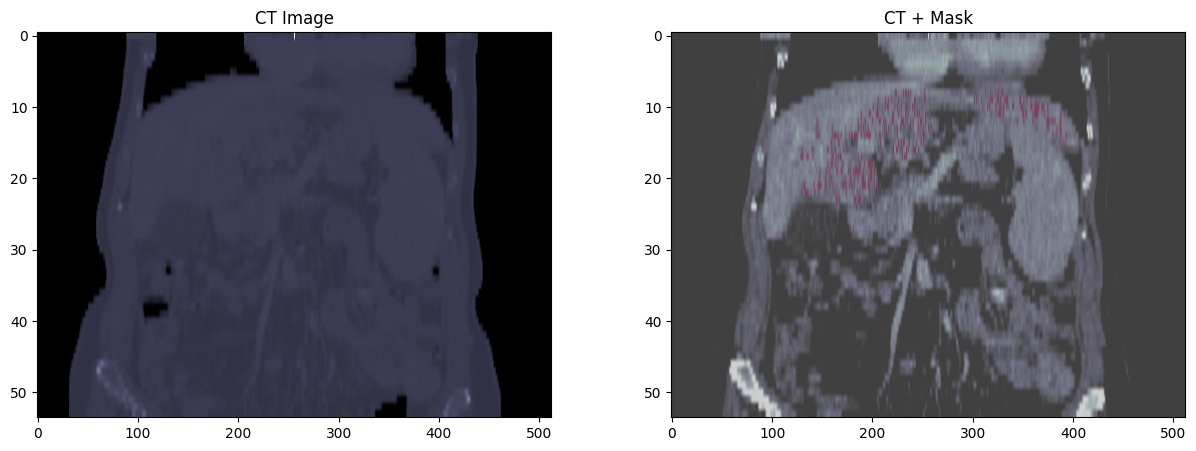

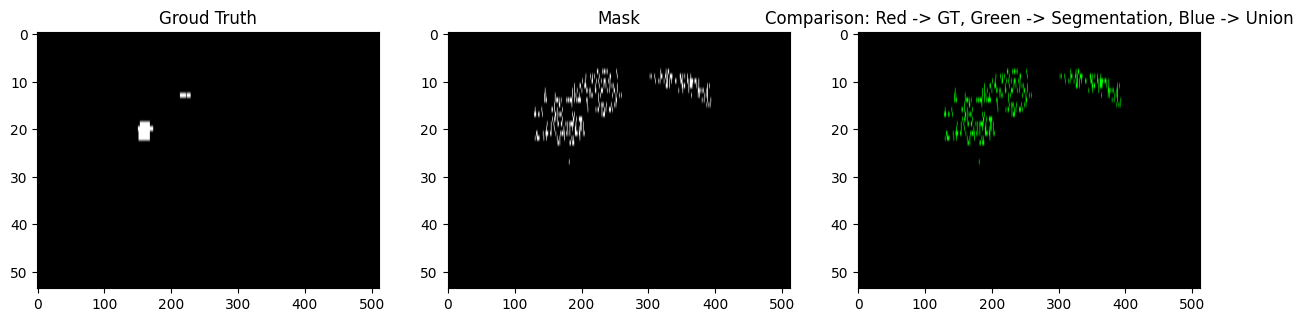

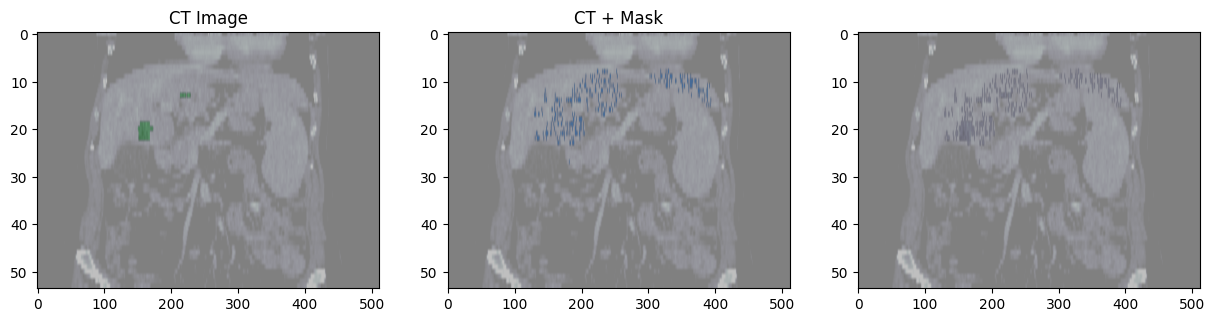

In [27]:
plot_ct_and_segmentation(final_mask,200,'coronal',0.25)
plot_gt_and_segmentation(final_mask,tumor_volume,200,'coronal')
plot_all(final_mask,tumor_volume,200,'coronal',0.5)

In [28]:
print(perpixel_performance_measures(tumor_volume, mask[1]))
print(perimage_performance_measures(tumor_volume, final_mask))
print(dice_coefficient(tumor_volume, final_mask))

(np.int64(0), np.int64(14149434), np.int64(0), np.int64(0))
(np.float64(nan), np.float64(0.9967536510647705), np.float64(0.0))
0.08024340499515197


C:\Users\Aina\AppData\Local\Temp\ipykernel_15988\3159552078.py:4: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = tp / (tp + fn)


7279
512
988


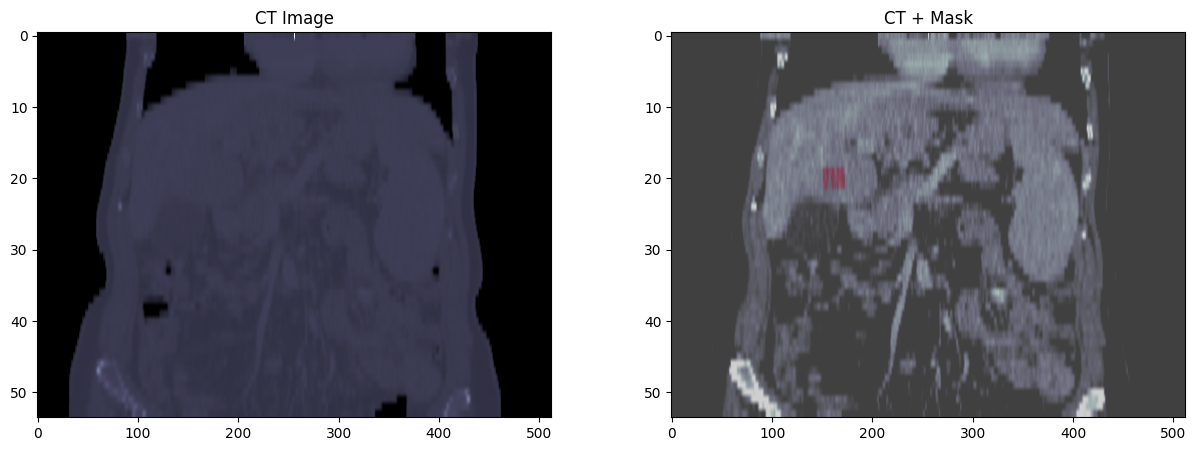

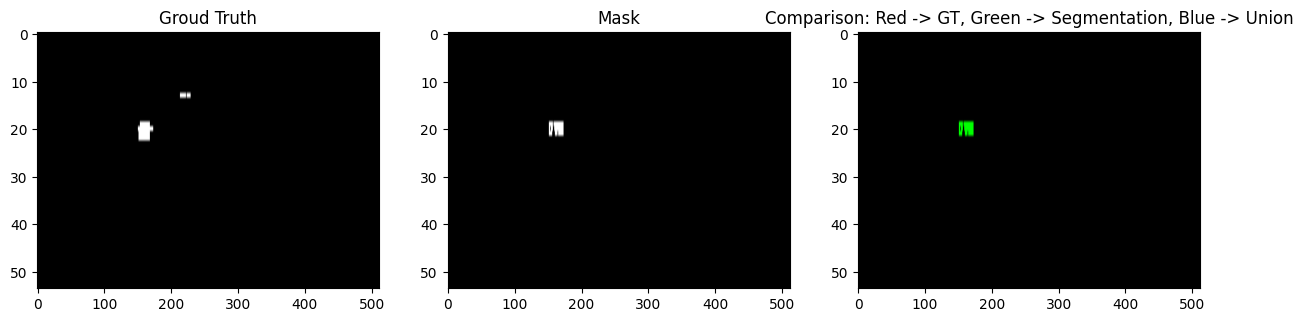

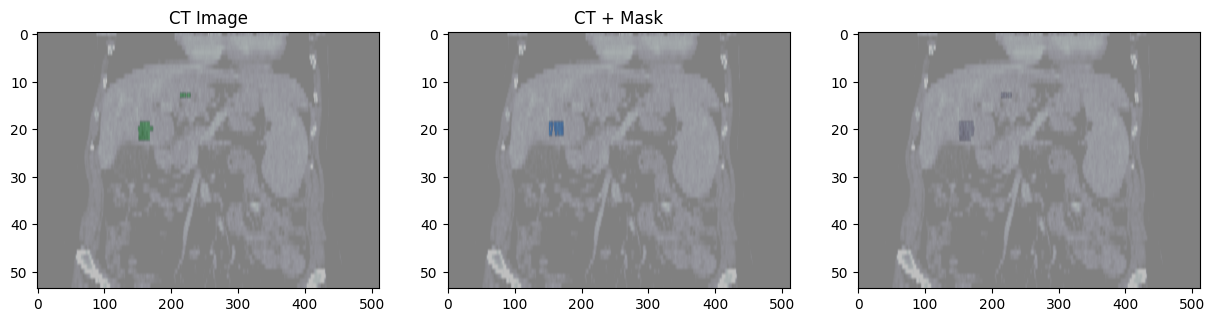

In [82]:
masks = []

for c, bbox in zip(centroids, bboxes):
    mask = flood(ct_volume, seed_point=c, tolerance=30)

    (zmin, zmax), (ymin, ymax), (xmin, xmax) = bbox
    full_mask = np.zeros_like(ct_volume, dtype=bool)
    full_mask[zmin:zmax, ymin:ymax, xmin:xmax] = mask[zmin:zmax, ymin:ymax, xmin:xmax]

    masks.append(full_mask)
    print(np.sum(full_mask))

plot_ct_and_segmentation(full_mask,200,'coronal',0.25)
plot_gt_and_segmentation(full_mask,tumor_volume,200,'coronal')
plot_all(full_mask,tumor_volume,200,'coronal',0.5)

In [83]:
print(perpixel_performance_measures(tumor_volume, full_mask))
print(perimage_performance_measures(tumor_volume, full_mask))
print(dice_coefficient(tumor_volume, full_mask))

(np.int64(0), np.int64(14149037), np.int64(397), np.int64(0))
(np.float64(nan), np.float64(0.9999719423405912), np.float64(0.0))
0.17290813341135167


C:\Users\Aina\AppData\Local\Temp\ipykernel_15988\3159552078.py:4: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity = tp / (tp + fn)
